In [6]:
import argparse
from tqdm import tqdm
import os
import PIL.Image as Image
from data import data_transforms
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from model import Net, load_res_50,Net_res101
import numpy as np
from torchvision.utils import save_image
import torchvision.transforms as transforms


# Data transforms


In [3]:
def find_mean_std(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data,_ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std
    

#(tensor([0.5079, 0.5221, 0.4361]), tensor([0.2079, 0.2069, 0.2217])) on val
#(tensor([0.4921, 0.5084, 0.4645]), tensor([0.1631, 0.1649, 0.1810])) on images

cust = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


# Loaders

In [4]:
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("bird_dataset/val_images", transform=data_transforms),
    batch_size=1,
    shuffle=False,
    num_workers=1,
)

val_loader2 = torch.utils.data.DataLoader(
    datasets.ImageFolder("bird_dataset2/val_images", transform=data_transforms),
    batch_size=1,
    shuffle=True,
    num_workers=1,
)


# Models

In [7]:
# model = Net()
# model.load_state_dict( torch.load("models/model91.pth",map_location=torch.device('cpu')))
# model.eval()

models = []

for model_str in ["models/model91.pth","models/model91_2.pth"]:
    model = Net_res101()
    model.load_state_dict( torch.load(model_str,map_location=torch.device('cpu')))
    model.eval()
    models.append(model)


In [10]:
t = next(iter(val_loader2))

In [24]:
def ensemble_voting(models, data):
    outputs = []
    max_ = None
    ind_ = None
    for model in models:
        modelax = model(data).data.max(1)

        if max_ is None or max_<modelax[0]:
            max_ = modelax[0]
            ind_ = modelax[1]
    return ind_
    if outputs[0]==outputs[1]:
        return outputs[0]
    return outputs[2]

    
# models=[model]
ensemble_voting(models,t[0])[0]

tensor(15)

# Resize images in a folder

In [131]:
def pil_load_and_resize(path, size=224):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        with Image.open(f) as img:
            img = img.resize((size,size))
            img = img.convert("RGB")
            return img
            
def resize_images(or_dir):
    for dir in os.listdir(or_dir):
        if dir[0] != ".":
            test_dir = or_dir+dir
            for f in tqdm(os.listdir(test_dir)):
                if "png" in f or "jpg" in f:
                    try:
                        name = test_dir + "/" + f
                        data = pil_load_and_resize(name)
                        data.save(name)
                    except:
                        print(name)
                    # find_best_match(data)    

# Test model on dataset

In [135]:
len(val_loader2)

100

In [25]:
def val_test(models, loader):
    valid = []
    invalid = []
    correct = 0
    for data, target in loader:
        pred = ensemble_voting(models, data)
        diff = pred - target.data.view_as(pred)
        for i in range(len(diff)):
            if diff[i]==0:
                valid.append(data)
            else:
                invalid.append(data)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    print(100.0 * correct / len(loader.dataset))
    return valid,invalid

val_test(models,val_loader2)

tensor(91.2621)


([tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            ...,
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
            [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
  
           [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            ...,
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
            [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
  
           [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.804

# Manipulate model output

In [24]:
def find_max(tens):
    '''returns index of max, max, secondmax'''
    arr = tens.clone().flatten().detach().numpy()
    ind =np.argmax(arr)
    arr[ind]*=-1
    ind2 =np.argmax(arr)
    arr[ind]*=-1
    return ind,arr[ind], arr[ind2]

def prob_img(img):
    data = data_transforms(img)
    output = torch.softmax(model(data.unsqueeze(0)),1)
    return output

def find_best_match(img):
    output = prob_img(img)
    return find_max(output)

find_best_match(pil_load_and_resize("images/0474/0bfa16b45add4ec2bce9fa93fc808927.jpg"))

(12, 0.99393266, 0.0014698163)

In [8]:
def assign_pseudolabel(model, or_dir="images/", tar_dir="pseudo_label/"):
    model.eval()
    c = 0
    for dir in os.listdir(or_dir):
        if dir[0] != ".":
            test_dir = or_dir + dir
            for f in tqdm(os.listdir(test_dir)):
                if "png" in f or "jpg" in f:
                    name = test_dir + "/" + f
                    img = pil_load_and_resize(name)
                    data = data_transforms(img)
                    output = model(data[None, :])
                    index = find_max(torch.softmax(output,1))
                    print(index)
                    if index[1]>0.5:
                        c += 1
                        dos = str(index[0])
                        if index[0] < 10:
                            dos = "0" + dos
                        img.save(tar_dir + dos + "/" + str(c) + ".jpg")

# assign_pseudolabel(model2)

In [31]:
# adds data to pseudo label
def add_known_data_to_pseudo_folder():
    or_dir = "bird_dataset/train_images/"
    c=-1
    dirs = []
    for dir in os.listdir(or_dir):
            if dir[0] != ".":
                dirs.append(dir)
    dirs.sort()
    print(dirs)
    for dir in dirs:
        print(dir)
        test_dir = or_dir+dir
        c+=1
        for f in tqdm(os.listdir(test_dir)):
            if "png" in f or "jpg" in f:
                name = test_dir + "/" + f
                data = pil_load_and_resize(name)
                if c<10:
                    data.save( "pseudo_label/0"  +str(c)+"/"+ f)
                else:
                    data.save( "pseudo_label/"  +str(c)+"/"+ f)
                   


In [32]:
def find_label(loader, n=3000):
    c = 3000
    tc = 0
    for data, _ in loader:
        output = model(data)
        res = find_max(torch.sigmoid(output))
        tc+=1
        if res[1]>0.99:
            c+=1
            save_image(data[0], "pseudo_label/"+str(res[0])+"/"+str(c)+".jpg")
            # print(res[0], c)
        print(tc/n)
        if tc>n:
            return

In [64]:
def show_confidence(loader):
    d={i:[] for i in range(20)}
    for data, label in loader:
        index = int(label.data[0])
        output = model(data)
        d[index].append(torch.softmax(output,1).detach().numpy()[0])
    return d

d = show_confidence(val_loader)

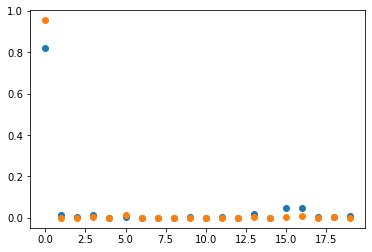

In [84]:
def plot_arrays(arrays,i):
    for arr in arrays:
        plt.plot(arr, 'o')
    plt.show()

i=0
plot_arrays(d[i],i)

In [86]:
t

[tensor([[[[ 1.4440,  1.4269,  1.4440,  ...,  1.9235,  1.9064,  1.8550],
           [ 1.4098,  1.4269,  1.4440,  ...,  1.8379,  1.8379,  1.8037],
           [ 1.4098,  1.4269,  1.4440,  ...,  1.7523,  1.7523,  1.7352],
           ...,
           [ 0.2111,  0.2796,  0.2453,  ...,  0.6049,  0.4166,  0.2111],
           [ 0.0569,  0.1768,  0.1597,  ...,  0.6392,  0.3652,  0.0398],
           [-0.0972,  0.0056,  0.0227,  ...,  0.5878,  0.2453, -0.0458]],
 
          [[ 1.2206,  1.2031,  1.2206,  ...,  1.7633,  1.7283,  1.6583],
           [ 1.1856,  1.2031,  1.2206,  ...,  1.6758,  1.6933,  1.6583],
           [ 1.1856,  1.2031,  1.2206,  ...,  1.5707,  1.5882,  1.5707],
           ...,
           [ 0.1877,  0.2752,  0.2927,  ...,  0.7479,  0.5903,  0.2752],
           [ 0.0126,  0.1702,  0.1877,  ...,  0.7829,  0.5728,  0.1702],
           [-0.1625, -0.0399,  0.0126,  ...,  0.7479,  0.4678,  0.1176]],
 
          [[ 1.1934,  1.1759,  1.1934,  ...,  1.7163,  1.6814,  1.6291],
           [ 

In [91]:
print(find_max(model(t[0])))
print(find_max(model2(t[0])))
print(find_max(model3(t[0])))

(0, 4.959557, 2.1259172)
(0, 3.4655128, 1.5907052)
(0, 5.5536, 2.4188097)


# Find classes

In [19]:
def show_confidence(model, loader):
    d={i:[] for i in range(20)}
    for data, label in loader:
        index = int(label.data[0])
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        true_guess = pred.eq(label.data.view_as(pred)).cpu().sum()
        d[index].append(int(true_guess))
    return d

d2 = show_confidence(model2,val_loader)

In [20]:
d

{0: [1, 1],
 1: [1, 0, 1, 1],
 2: [0, 1, 1, 1, 1, 1, 1],
 3: [1, 1, 1],
 4: [1, 1],
 5: [1, 1],
 6: [1, 1, 1],
 7: [1, 0, 1, 1],
 8: [1, 1, 0, 1, 1, 1],
 9: [1, 1, 1, 1, 1],
 10: [1, 1, 1, 1, 1, 1, 1, 1],
 11: [1, 1, 1, 1, 1, 1],
 12: [1, 1, 1, 1, 1, 1],
 13: [1, 1, 0, 1, 1, 1, 1, 0],
 14: [1, 1, 1, 1, 0, 1, 1],
 15: [1, 0, 1, 1, 0, 0, 0],
 16: [0, 0, 1, 0, 0, 1],
 17: [0, 0, 1, 1, 1],
 18: [1, 0, 1, 1],
 19: [1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
d2

{0: [1, 1],
 1: [1, 0, 1, 0],
 2: [0, 1, 1, 1, 1, 1, 1],
 3: [0, 1, 1],
 4: [1, 1],
 5: [1, 1],
 6: [1, 1, 1],
 7: [1, 0, 1, 1],
 8: [1, 1, 1, 1, 1, 1],
 9: [1, 1, 1, 1, 1],
 10: [1, 1, 1, 1, 1, 1, 1, 1],
 11: [1, 1, 1, 1, 1, 1],
 12: [1, 1, 1, 1, 1, 1],
 13: [1, 1, 0, 1, 1, 1, 1, 0],
 14: [1, 1, 1, 1, 0, 1, 1],
 15: [1, 1, 1, 1, 0, 0, 1],
 16: [0, 0, 1, 0, 0, 1],
 17: [0, 0, 1, 0, 1],
 18: [1, 1, 1, 1],
 19: [0, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
def show_stat(d):
    L=[]
    for e in d:
        L.append(sum(d[e])/len(d[e]))
    return L

L = show_stat(d)
L2 = show_stat(d2)


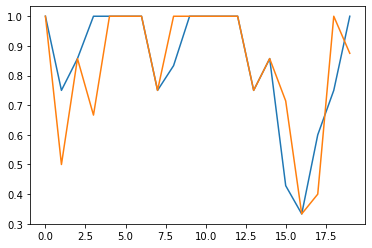

In [25]:
plt.plot(L)
plt.plot(L2)